In [50]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [39]:
mnist_builder = tfds.builder('mnist')
mnist_builder.download_and_prepare()
# тасование отключаем, потому что сначала хотим разделить выборку на обучающую и проверочную. 
# Если тасование будет включено, то модель образцы для обучения и проверки будут перемешаны друг с другом 
# и оценка модели каждый раз будет разной => нерепрезентативной
datasets = mnist_builder.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

In [40]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 10

mnist_train = mnist_train_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                               tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [41]:
model = tf.keras.models.Sequential([
    # filters - кол-во карт признаков, kernel_size - размер фильтра, strides - понятно, padding - тип дополнения, activation - функция активации
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', data_format="channels_last", name="conv_1", activation='relu'), 
    # pool_size - размер фильтра, strides - понятно, padding - тип дополнения
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', name="conv_2", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool_2"),
])

In [42]:
model.compute_output_shape(input_shape=(64, 28, 28, 1))

(64, 7, 7, 64)

In [43]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(64, 28, 28, 1))

(64, 3136)

In [44]:
model.add(tf.keras.layers.Dense(units=1024, name="fc_1", activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name="fc_2", activation='softmax'))

In [45]:
model.build(input_shape=(64, 28, 28, 1))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [46]:
history = model.fit(x=mnist_train, epochs=NUM_EPOCHS, validation_data=mnist_valid, shuffle=True)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.9009 - loss: 0.3104 - val_accuracy: 0.9795 - val_loss: 0.0650
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9857 - loss: 0.0482 - val_accuracy: 0.9863 - val_loss: 0.0464
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.9887 - val_loss: 0.0375
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9929 - loss: 0.0222 - val_accuracy: 0.9896 - val_loss: 0.0398
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9944 - loss: 0.0190 - val_accuracy: 0.9881 - val_loss: 0.0479
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9946 - loss: 0.0160 - val_accuracy: 0.9878 - val_loss: 0.0509
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.9889 - val_loss: 0.0508
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9957 - loss: 0.0137 - 

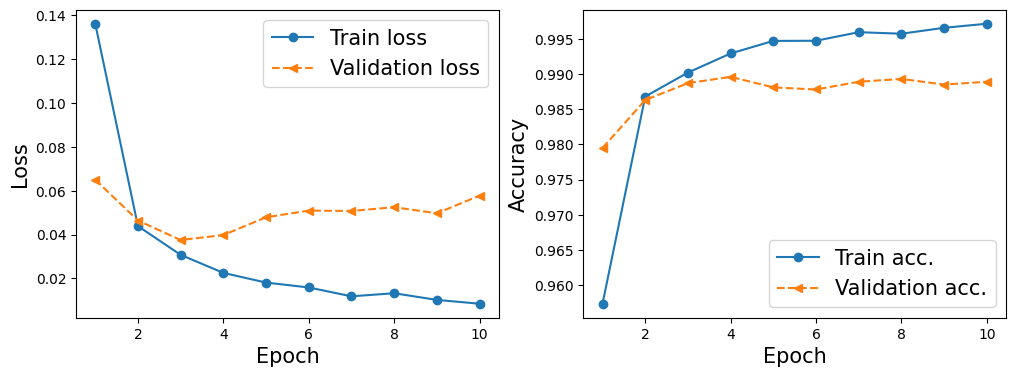

In [47]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9913 - loss: 0.0381

Test Acc. 99.14%
TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


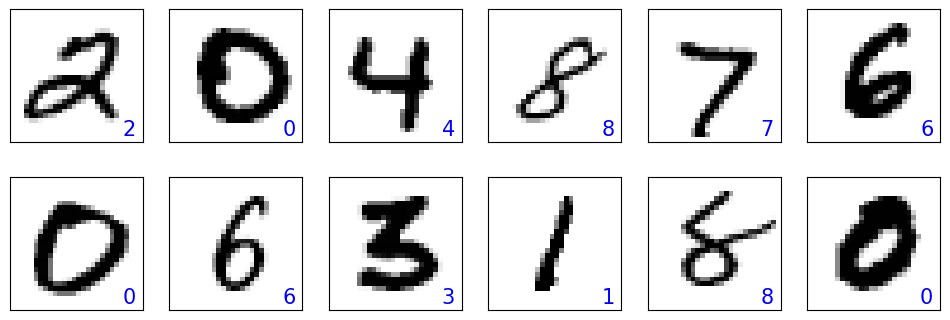

In [48]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

In [52]:
if not os.path.exists('models'):
    os.mkdir('models')


model.save('models\\mnist-cnn.keras')